In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
transform1 = transforms.Compose([transforms.Resize(28), # Change size if needed
                                 transforms.ToTensor()])

# download train dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=True,
                                           transform=transform1,
                                           download=True)

# download test dataset
test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=False,
                                           transform=transform1,
                                           download=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
batch_size = 32

# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader =  torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

torch.Size([32, 1, 28, 28])


Text(0.5, 1.0, 'tensor(7)')

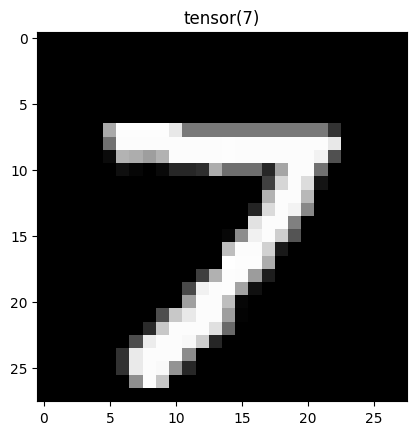

In [ ]:
# Check out the 
X, y = next(iter(train_loader))
print(X.shape)

img = transforms.ToPILImage()(X[0])
plt.imshow(img,cmap='gray')
plt.title(y[0])


In [ ]:
# Patchify
# Split image into 7x7 patches, then vectorize. Image size is 28x28. Each patch is 4x4.
# N,1,28,28 --> N, 49, 16

def patchify(images,n_patches=7):
  n, c, h, w = images.shape

  patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2 )
  patch_size = h // n_patches # 4

  for idx, image in enumerate(images):
    for i in range(n_patches):
      for j in range(n_patches):
        patch = image[:, i * patch_size: (i+1) * patch_size, j * patch_size: (j+1)*patch_size]
        patches[idx, i * n_patches + j ] = patch.flatten()
  
  return patches


In [ ]:
X, y = next(iter(train_loader))
patches = patchify(X)
print(patches.shape)

torch.Size([32, 49, 16])


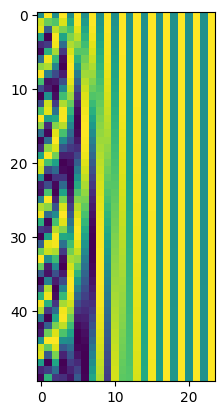

In [ ]:
# Positional encoding
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

pos_enc = get_positional_embeddings(50, 24)
plt.imshow(pos_enc)


In [ ]:
# Multi-Head Self Attention
class MyMSA(nn.Module):
  def __init__(self, d, n_heads=2):
    super().__init__()

    self.d = d  # embedding dimension
    self.n_heads = n_heads

    d_head = int(d / n_heads) # dimension of each head
    self.d_head = d_head

    # Use ModuleList to list modules to be appended
    self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for i in range(self.n_heads)]) 
    self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for i in range(self.n_heads)]) 
    self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for i in range(self.n_heads)]) 

    self.softmax = nn.Softmax(dim=-1)
  
  def forward(self, sequences):
    # sequences has shape (N, seq_length, token_dim)
    # Map it to shape (N, seq_length, n_heads, token_dim / n_heads)
    # And then, go back to (N, seq_length, token_dim) using concatenation
    
    result = []
    for sequence in sequences:
      seq_result = []
      for head in range(self.n_heads):
        q_mapping = self.q_mappings[head] # each is a nn.Linear
        k_mapping = self.k_mappings[head]
        v_mapping = self.v_mappings[head]

        # Get part of a sequence
        seq = sequence[:, head * self.d_head: (head+1) * self.d_head]

        # And apply the mapping
        q = q_mapping(seq)
        k = k_mapping(seq)
        v = v_mapping(seq)

        # Attention
        attention = self.softmax(q @ k.T / (self.d_head)**0.5 )
        seq_result.append(attention @ v)
      
      result.append(torch.hstack(seq_result))
    
    return torch.cat([torch.unsqueeze(r,dim=0) for r in result])


In [ ]:
msa = MyMSA(8)
X, y = next(iter(train_loader))
out = patchify(X)
print(out.shape)
out2 = msa(out)
print(out2.shape)

torch.Size([32, 49, 16])
torch.Size([32, 49, 8])


In [ ]:
class MyViTBlock(nn.Module):
  def __init__(self, hidden_d, n_heads, mlp_ratio=4):
    super().__init__()
    
    self.hidden_d = hidden_d
    self.n_heads = n_heads

    self.norm1 = nn.LayerNorm(hidden_d)
    self.mhsa = MyMSA(hidden_d, n_heads)
    self.norm2 = nn.LayerNorm(hidden_d)
    self.mlp = nn.Sequential(
        nn.Linear(hidden_d, mlp_ratio * hidden_d),
        nn.GELU(),
        nn.Linear(mlp_ratio * hidden_d, hidden_d)
    )
  
  def forward(self, x):
    out = x + self.mhsa(self.norm1(x))
    out = out + self.mlp(self.norm2(out))
    
    return out

In [ ]:
model_vitblock = MyViTBlock(8,2)
x = torch.randn(32,50,8)
out = model_vitblock(x)
print(out.shape)


torch.Size([32, 50, 8])


In [ ]:
# ViT

class MyViT(nn.Module):
  def __init__(self, chw=(1,28,28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
    super().__init__()
    
    self.chw = chw
    self.n_patches = n_patches
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    self.n_blocks = n_blocks
    self.hidden_d = hidden_d
    self.n_heads = n_heads

    # 1) Linear mapping
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1]) 
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # 2) Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # 3) Positional embedding
    pos_enc = get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)
    self.pos_embed = nn.Parameter(torch.tensor(pos_enc))
    self.pos_embed.requires_grad = False

    # 4) Transformer blocks
    self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for i in range(n_blocks)])

    # 5) Classifier
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_d, out_d),
        nn.Softmax(dim=-1)
    )

  def forward(self, X):
    patches = patchify(X, self.n_patches)
    tokens = self.linear_mapper(patches)

    # Add the classification token for each image
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Add positional embedding
    pos_embed = self.pos_embed.repeat(tokens.size(0),1,1)
    out = tokens + pos_embed

    # Transformer blocks
    for block in self.blocks:
      out = block(out)
    
    # Get the classification token
    out = out[:,0]

    # Classifier mapping
    out = self.mlp(out)

    return out
  

In [ ]:
model = MyViT(
    chw=(1,28,28),
    n_patches=7)

X, y = next(iter(train_loader))
out = model(X)
print(out.shape)



torch.Size([32, 10])


<ipython-input-65-d35ebdd75655>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos_embed = nn.Parameter(torch.tensor(pos_enc))


In [ ]:
# Training
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

N_EPOCHS = 5

model.to(device)
for epoch in range(N_EPOCHS):
  total_loss = 0.0
  for X,y in train_loader:
    X = X.to(device)
    y = y.to(device)
    y_hat = model(X)

    loss = criterion(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.detach().cpu().item() / len(train_loader)
  
  print("Epoch: ", epoch, " Loss: ", total_loss)



Epoch:  0  Loss:  2.1244891506830874
Epoch:  1  Loss:  1.9946678010940555
Epoch:  2  Loss:  1.987931413269048
Epoch:  3  Loss:  2.018713233057661
Epoch:  4  Loss:  2.0745009867350244
